#### Сравнение групп

Вместо выполнения проверок гипотез мы выберем другой путь и сосредоточимся на оценке размера эффекта (effect size), то есть на количественной оценке различий между двумя группами.

Соответственно, размер эффекта (effect size) – это всего способ числовой оценки размера различий между двумя группами.

Преимуществом подхода с использованием размера эффекта является отказ от типа вопросов, требующих ответов

`да/нет; действует ли это? возникает ли какой-либо эффект?`,

– и переход к более точным вопросам типа:

`насколько хорошо это действует? насколько велик/мал эффект?`

Будем пытаться получить апостериорное распределение различий в средних значениях между группами, а не только точечную оценку различий.

Для визуального наблюдения и интерпретации такого апостериорного распределения воспользуемся тремя инструментами:

* график апостериорного распределения с эталонным (нормальным) значением;
* d-мера Коэна [Cohen’s d, wiki](https://en.wikipedia.org/wiki/Effect_size), [Interpreting Cohen's d Effect Size](https://rpsychologist.com/cohend/), [Nonparametric Cohen's d-consistent effect size](https://aakinshin.net/posts/nonparametric-effect-size/);
$$d = \frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma^2_2+\sigma^2_1}{2}}}$$

Т.е., __d-мера Коэна__ – это способ измерения размера эффекта, при котором разность средних значений нормализуется с учетом объединенных стандартных отклонений для обеих групп. Так как можно получить апостериорное распределение средних значений и стандартных отклонений, можно также вычислить апостериорное распределение значений d-меры Коэна.


d-меру Коэна можно интерпретировать как стандартизированную оценку (z-оценку).
Стандартизированная оценка – это число (со знаком) стандартных отклонений, на которое некоторое значение отличается от среднего значения для наблюдаемого или измеряемого объекта или явления (то есть мера относительного разброса наблюдаемого или измеряемого значения). Таким образом, d-меру Коэна, равную 0.5, можно интерпретировать как различие в 0.5 стандартного отклонения одной группы по отношению к другой.


* вероятность превосходства [probability of superiority, not original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6008517/).

__Вероятность превосходства__ - это альтернативный метод описания размера эффекта, который определяется как вероятность того, что точка данных, выбранная случайным образом из одной группы, имеет большее значение, чем точка данных, также случайным образом выбранная из другой группы.

__Если предположить, что распределение исследуемых данных является нормальным__, то можно вычислить вероятность превосходства по d-мере Коэна:

$$ps=\Phi(\frac{\sigma}{\sqrt{2}})$$

$\Phi-$ совокупное нормальное распределение;

$\sigma-$ d-мера Коэна.

__Поскольку мы будем располагать выборками из апостериорного распределения, можно напрямую вычислять вероятность превосходства__. Это чрезвычайно значительное преимущество при использовании методов Монте-Карло с использованием цепей Маркова (Markov chain Monte Carlo – MCMC) – поскольку выборки получаются из апостериорного распределения, становится возможным вычисление многих величин.

Для практических исследований используем датасет `tips`. Необходимо исследовать влияние дня недели на сумму чаевых, оставляемых посетителями ресторана. Соответственно, исследуемые группы - дни недели. Как таковые контрольная и экспериментальная группы отсутствуют. При необходимости можно установить один день в качестве контрольной группы.

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext watermark
%watermark --iversions

pymc3     : 3.10.0
numpy     : 1.19.2
seaborn   : 0.10.0
scipy     : 1.5.2
arviz     : 0.11.1
matplotlib: 3.4.2
pandas    : 1.1.4



In [3]:
df_data = pd.read_csv('data/tips.csv')

In [4]:
df_data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
df_data.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [7]:
df_data.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


Будем использовать только значения `tip` и `day`.

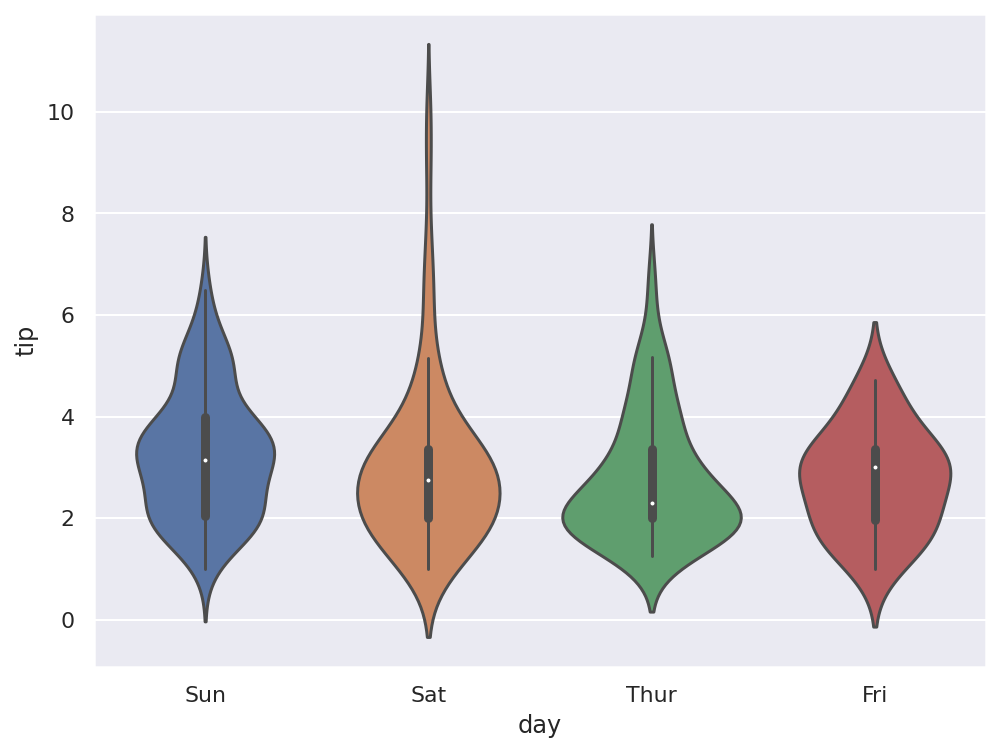

In [8]:
fig=plt.figure(figsize=(8,6))
sns.violinplot(x='day', y='tip', data=df_data)
plt.show()

In [9]:
tip = df_data['tip'].values
idx = pd.Categorical(df_data['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [10]:
groups

4

In [11]:
idx.shape

(244,)

$\mu$, $\sigma$ в данной постановке уже не скаляры, а вектора.

Это означает, что для априорных распределений передается аргумент shape, а для функции правдоподобия соответствующим образом индексируются переменные means и sds с использованием переменной idx.

In [12]:
with pm.Model() as comparing_groups:
    
    mu = pm.Normal('mu', mu=0, sd=10, shape=groups)
    sigma=pm.HalfNormal('sigma', sd=10, shape=groups)
    y = pm.Normal('y', mu=mu[idx], sd=sigma[idx], observed=tip)
    
    trace_cg = pm.sample(5000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.


Закодированные дни недели:

`0: 'Thur', 1: 'Fri', 2: 'Sat', 3: 'Sun'`

In [13]:
az.from_pymc3(trace_cg)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

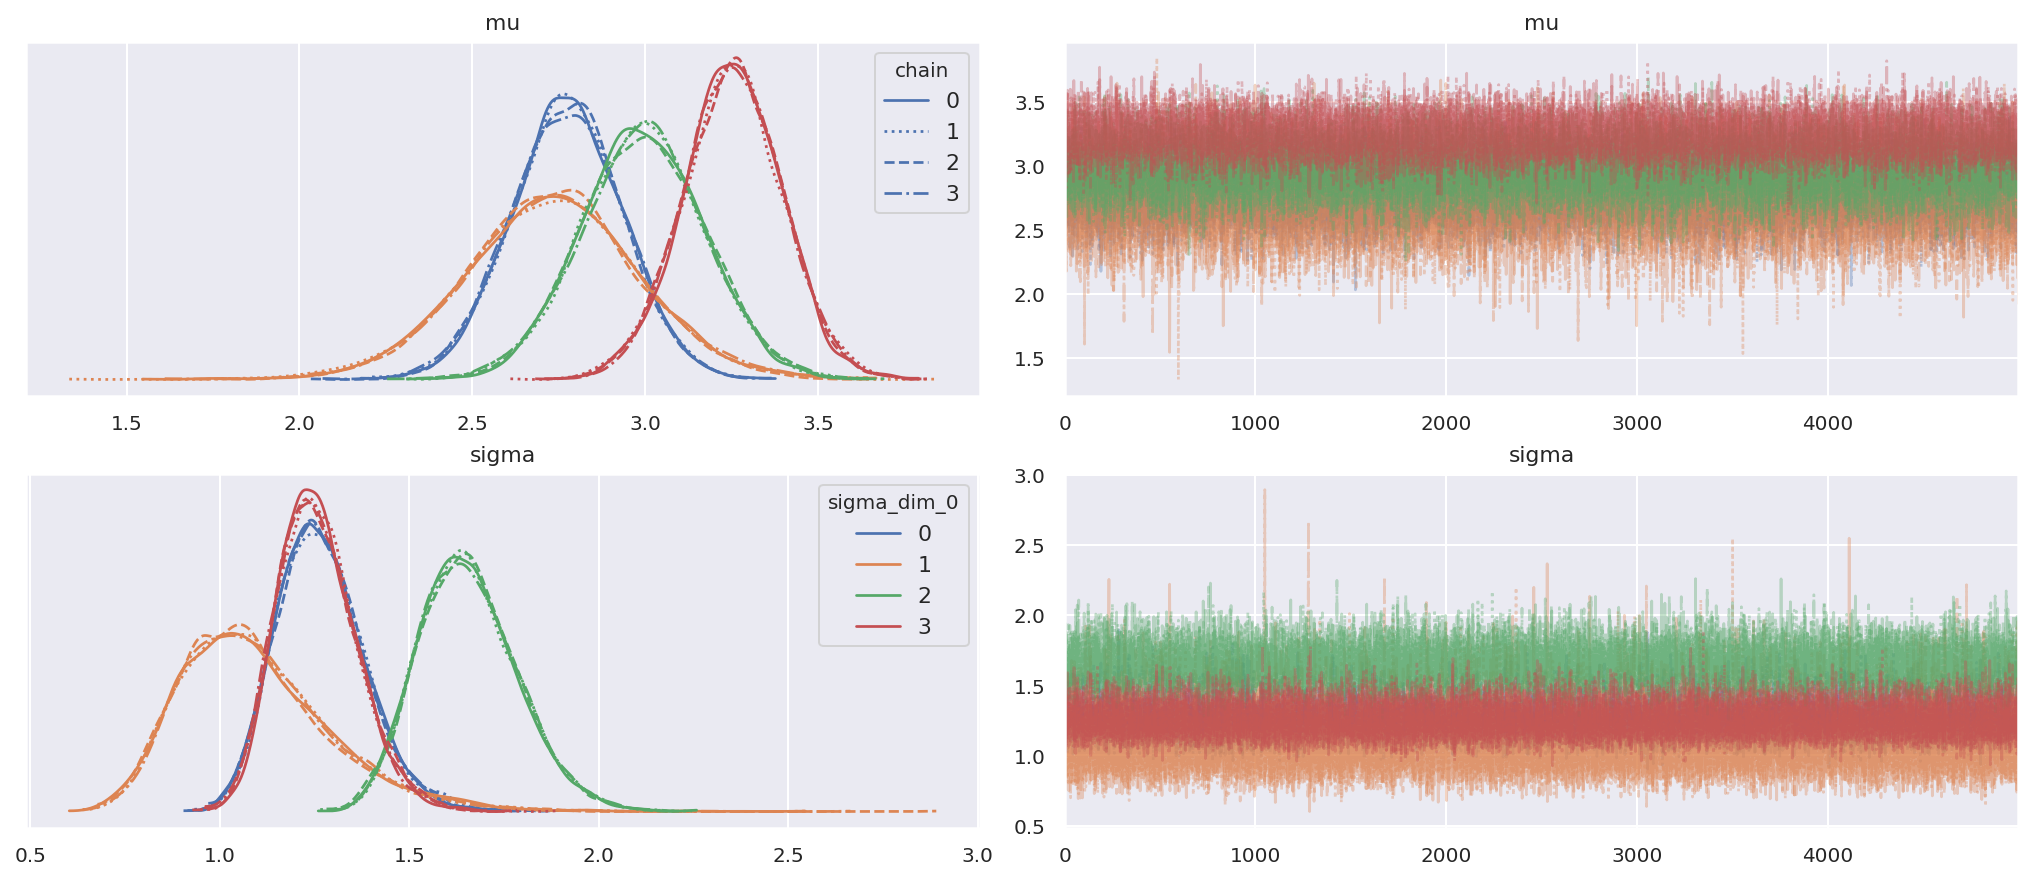

In [14]:
mu_plots, sigma_plots = az.plot_trace(trace_cg, figsize=(14, 6), legend=True)
plt.show()

Оценим меру Коэна, вероятность превосходства и нанесем информацию на интервал плоности апостериорного распределения наименьшей длины (ПАР, HPD).

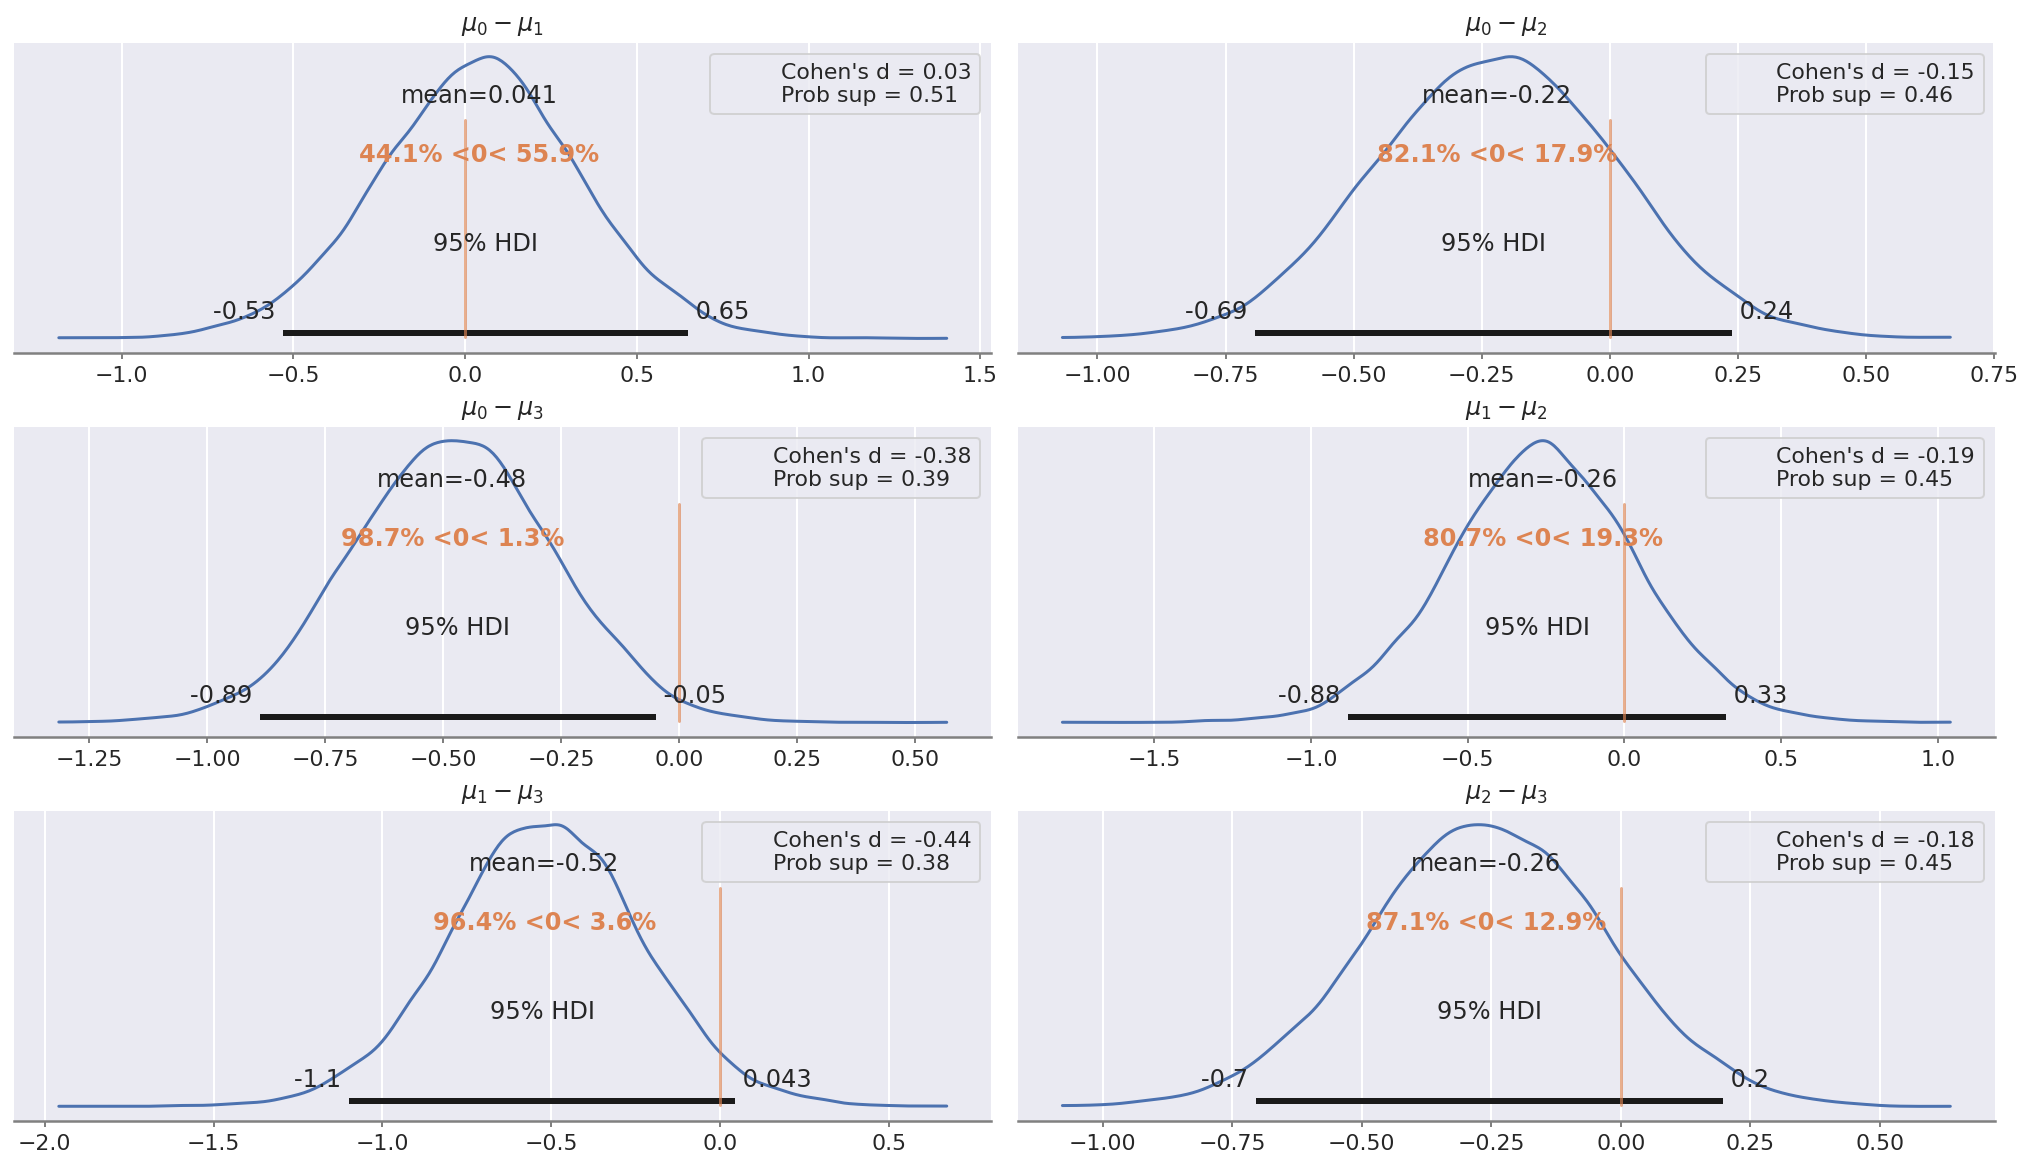

In [15]:
alpha = 0.95
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)
comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['mu'][:, i] - trace_cg['mu'][:, j]
    
    d_cohen = (means_diff / np.sqrt((trace_cg['sigma'][:, i]**2 + trace_cg['sigma'][:, j]**2)/ 2 )).mean()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], hdi_prob=alpha)
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()

В первую очередь графики плотности апостериорных распределений показывают, что с P=95% есть различие в чаевых только между четвергом и воскресеньем ($\mu_0-\mu_3$), поскольку 0 не входит в заданный интервал. 

Для всех остальных примеров невозможно исключить вероятность нулевого различия (по критерию перекрытия ПАР и эталонного значения).

Но даже в этом случае можно ли считать различие приблизительно в 0.5 доллара довольно большим? Это вопрос практической значимости, который должен обсуждаться неотрывно от предметной области. 

Вероятно, в данном случае результат не несет очень большой практической значимости, если мы рассматриваем данные за одно небольшое кафе. Если же это было первичное исследование, или PoC - Proof of Concept на одном из ресторанов сети, то с парктической точки зроения можно было бы задуматься о расширении исследуемого числа точек ресторана.

Что же касается коэффициента Коэна, на основе которого с помощью МСМС мы можем рассчитать вероятность превосходства, то интерпретация совпадает с итерпретацией HPD.

Для среднего чека между четвергом и воскресеньем `prob sup = 0.61`. Соответственно, с вероятностью 61% случайно выбранный визит в воскресенье будет иметь больший чек, чем случайно выбранный визит в четверг.

Несмотря на то, что `prob sup = 0.62` для сравнения средних чеков пятницы и воскресенья тоже достаточно большой, 0 все же входит в HPD.